In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import cv2
import os
from tqdm import tqdm
from keras.utils import img_to_array
from keras.utils import load_img
import matplotlib.pyplot as plt
from skimage import color, morphology 

In [2]:
def smoothening_kernel(sigma=2):
    kernel_size = int(sigma * 3)
    kernel = np.zeros((kernel_size, kernel_size))
    
    for i in range(kernel_size):
        for j in range(kernel_size):
            x = i - kernel_size // 2
            y = j - kernel_size // 2
            kernel[i][j] = np.exp(-(x**2 + y**2)/ (2*np.pi*sigma**2))   

    kernel /= kernel.sum()
    return kernel

In [3]:
def smoothening(img, kernel):
  smoothened_img = cv2.filter2D(img, -1, kernel)
  return smoothened_img

In [4]:
def directional_derivatives(smoothened_img):
  horizontal_filter = [
      [-1, -2, -1],
      [-2, -3, -2],
      [2, 3, 2],
      [1, 2, 1]
  ]

  vertical_filter = [
      [-1, -2, 2, 1],
      [-2, -3, 3, 2],
      [-1, -2, 2, 1]
  ]

  horizontal_dd = np.zeros_like(smoothened_img)
  vertical_dd = np.zeros_like(smoothened_img)

  for channel in range(3):
    for i in range(2, smoothened_img.shape[0] - 2):
      for j in range(2, smoothened_img.shape[1] - 2):
        patch_h = smoothened_img[i-2:i+2, j-1:j+2, channel]
        patch_v = smoothened_img[i-1:i+2, j-2:j+2, channel]
        horizontal_dd[i, j, channel] = np.sum(patch_h * horizontal_filter)
        vertical_dd[i, j, channel] = np.sum(patch_v * vertical_filter)

  return horizontal_dd, vertical_dd

In [5]:
def non_directional_derivative(horizontal_dd, vertical_dd):
  non_dd = np.sqrt(np.sum(horizontal_dd**2, axis=2) + np.sum(vertical_dd**2, axis=2))
  return non_dd

In [6]:
def lower_threshold(non_directional_derivative):
  summation = 0
  for i in range(non_directional_derivative.shape[0]):
    for j in range(non_directional_derivative.shape[1]):
      summation += non_directional_derivative[i][j]

  threshold = 2.20 * (summation / (non_directional_derivative.shape[0] * non_directional_derivative.shape[1]))
  return threshold

In [7]:
def weak_edge_map(directional_derivatives, non_directional_derivative, img):
  horizontal_dd = directional_derivatives[0]
  vertical_dd = directional_derivatives[1]

  gx = cv2.cvtColor(horizontal_dd, cv2.COLOR_RGB2GRAY)
  gy = cv2.cvtColor(vertical_dd, cv2.COLOR_RGB2GRAY)
  threshold = lower_threshold(non_directional_derivative)
  weak_edges = np.zeros_like(img)

  for i in range(1, img.shape[0] - 1):
    for j in range(1, img.shape[1] - 1):
      val = non_directional_derivative[i, j]
      if val > threshold:
        if (val >= gx[i, j-1]) and (val >= gx[i, j+1]) and (val >= gy[i-1, j]) and (val >= gy[i+1, j]):
          weak_edges[i, j] = 1

  return weak_edges

In [8]:
def strong_edge_map(directional_derivatives, non_directional_derivative, img):
  horizontal_dd = directional_derivatives[0]
  vertical_dd = directional_derivatives[1]

  gx = cv2.cvtColor(horizontal_dd, cv2.COLOR_RGB2GRAY)
  gy = cv2.cvtColor(vertical_dd, cv2.COLOR_RGB2GRAY)
  threshold = 0.825
  strong_edges = np.zeros_like(img)

  for i in range(1, img.shape[0] - 1):
    for j in range(1, img.shape[1] - 1):
      cond1, cond2, cond3 = 0, 0, 0
      val = non_directional_derivative[i, j]

      if val > threshold:
        cond1 = 1
      if ((val >= gx[i, j-1]) and (val >= gx[i, j+1])) or ((val >= gy[i-1, j]) and (val >= gy[i+1, j])):
        cond2 = 1
      
      gradient_0 = abs(val - non_directional_derivative[i, j-1]) + abs(val - non_directional_derivative[i, j+1])
      gradient_1 = abs(val - non_directional_derivative[i-1, j]) + abs(val - non_directional_derivative[i+1, j])
      if gradient_0 > gradient_1:
        cond3 = 1

      if cond1 and cond2 and cond3:
        strong_edges[i, j] = 1

  return strong_edges

In [9]:
def thinning(img):
  gray = color.rgb2gray(img)
  thinned = morphology.thin(gray, max_num_iter=2)
  thinned = thinned.astype(np.float32)
  return thinned

In [10]:
def edge_map(img, kernel):
  smoothened_img = smoothening(img, kernel)
  horizontal_dd, vertical_dd = directional_derivatives(smoothened_img)
  non_dd = non_directional_derivative(horizontal_dd, vertical_dd)
  weak_map = weak_edge_map([horizontal_dd, vertical_dd], non_dd, img)
  strong_map = strong_edge_map([horizontal_dd, vertical_dd], non_dd, img)
  combined = np.maximum(strong_map, weak_map)
  thinned = thinning(combined)

  return thinned

In [11]:
def read_images(img_paths, target_size=(256, 256)):
  imgs = []
  for img_path in img_paths:
    img = img_to_array(load_img(img_path, target_size=target_size, color_mode='rgb'))
    img = img / 255.0
    imgs.append(img)
  imgs = np.array(imgs)
  return imgs

In [12]:
def store_edges(data_path, store_path):
  if not os.path.exists(store_path):
    os.makedirs(store_path)

  img_paths = []
  img_names = []
  for IMAGE_NAME in os.listdir(data_path):
    if IMAGE_NAME == '.DS_Store':
      continue
    img_names.append(IMAGE_NAME)
    img_path = os.path.join(data_path, IMAGE_NAME)
    img_paths.append(img_path)

  imgs = read_images(img_paths)
  kernel = smoothening_kernel()
  for i in tqdm(range(len(imgs))):
    edge = edge_map(imgs[i], kernel)
    IMAGE_NAME = img_names[i].split('.')[0]
    EDGE_MAP_NAME = IMAGE_NAME + '_EM.png'
    EDGE_MAP_PATH = os.path.join(store_path, EDGE_MAP_NAME)
    plt.imsave(EDGE_MAP_PATH, edge, cmap='gray')
  return


In [13]:
data_path='/Users/Harshit/Downloads/ds-.jpeg' 
store_path='/Users/Harshit/Downloads/ds-e.jpeg'

In [52]:
store_edges(data_path, store_path)

100%|██████████| 10000/10000 [12:08:00<00:00,  4.37s/it] 


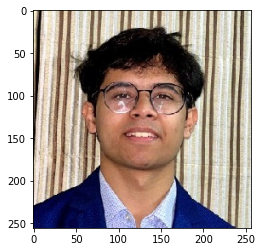

In [14]:
img_name = 'ds-.jpeg'
img = img_to_array(load_img('/Users/Harshit/Downloads/' + img_name, target_size=(256, 256)))
img = img / 255.0
plt.imshow(img)
plt.show()
path = os.path.join('/Applications/Capstone/Dataset/Conference/Results/Original', img_name)
plt.imsave(path, img)

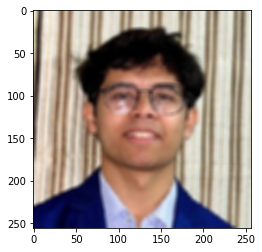

In [15]:
kernel = smoothening_kernel()
smoothened = smoothening(img, kernel)
plt.imshow(smoothened)
plt.show()
smoothened_img = 'smoothened-' + img_name
path = os.path.join('/Applications/Capstone/Dataset/Conference/Results/Smoothened', smoothened_img)
plt.imsave(path, smoothened)

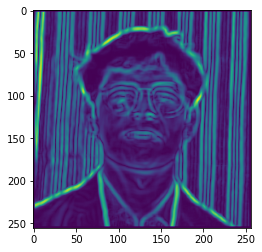

In [16]:
hdd, vdd = directional_derivatives(smoothened)
non_dd = non_directional_derivative(hdd, vdd)
plt.imshow(non_dd)
plt.show()
path = os.path.join('/Applications/Capstone/Dataset/Conference/Results/NDD', 'nondd-' + img_name)
plt.imsave(path, non_dd)

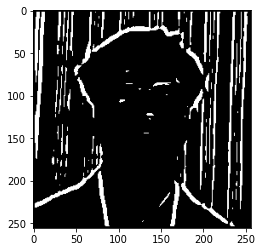

In [17]:
weak = weak_edge_map([hdd, vdd], non_dd, img)
plt.imshow(weak)
plt.show()
path = os.path.join('/Applications/Capstone/Dataset/Conference/Results/WEM', 'wem-' + img_name)
plt.imsave(path, weak)

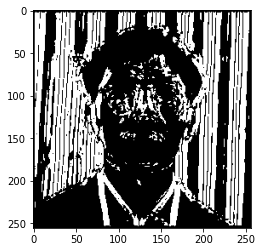

In [18]:
strong = strong_edge_map([hdd, vdd], non_dd, img)
plt.imshow(strong)
plt.show()
path = os.path.join('/Applications/Capstone/Dataset/Conference/Results/SEM', 'sem-' + img_name)
plt.imsave(path, strong)

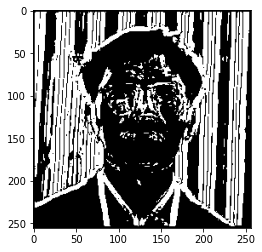

In [19]:
combined = np.maximum(strong, weak)
plt.imshow(combined)
plt.show()
path = os.path.join('/Applications/Capstone/Dataset/Conference/Results/COM', 'com-' + img_name)
plt.imsave(path, combined)

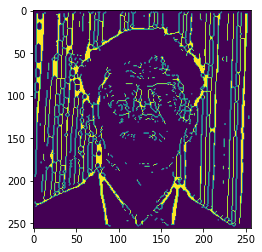

In [20]:
thinned = thinning(combined)
plt.imshow(thinned)
plt.show()
path = os.path.join('/Applications/Capstone/Dataset/Conference/Results/Thinned', 'thinned-' + img_name)
plt.imsave(path, thinned, cmap='gray')